# CSC 3105 Project

# Load and Clean the Data

This code block performs the following operations:

1. Imports necessary libraries for data handling and cleaning.
2. Defines a function `load_data` to load the data from a given directory into a pandas dataframe.
3. Defines a function `clean_data` to clean the loaded data. The cleaning process includes:
   - Handling missing values by dropping them.
   - Removing duplicate rows.
   - Converting the 'NLOS' column to integer data type.
   - Normalizing the 'Measured range (time of flight)' column.
   - Creating new features 'FP_SUM' and 'SNR'.
   - One-hot encoding categorical features.
   - Performing feature extraction on 'CIR' columns.
   - Dropping the original 'CIR' columns.
   - Checking for columns with only one unique value and dropping them.
4. Checks if a pickle file with the cleaned data exists. If it does, it loads the data from the file. If it doesn't, it loads and cleans the data using the defined functions.
5. Prints the first few rows of the cleaned data and its column headers.

In [1]:
import os

import numpy as np
import pandas as pd


DATASET_DIR = './UWB-LOS-NLOS-Data-Set/dataset'

def load_data(dataset_dir):
    # Load the data
    file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames]
    data = pd.concat((pd.read_csv(file_path) for file_path in file_paths))
    print(f"Original data shape: {data.shape}")
    return data


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def clean_data(data):
    print("Starting data cleaning process...")

    # Calculate total number of missing values in the data
    total_missing = data.isnull().sum().sum()
    print(f"Total number of missing values: {total_missing}")

    # Data has no missing values
    data = data.dropna()
    print("Missing values dropped.")

    # Data has no duplicate rows
    data = data.drop_duplicates()
    print("Duplicate rows dropped.")

    # Convert 'NLOS' column to integer data type (0 for LOS, 1 for NLOS)
    data['NLOS'] = data['NLOS'].astype(int)
    print("'NLOS' column converted to integer data type.")

    # Normalize 'Measured range (time of flight)' column using MinMaxScaler
    scaler = MinMaxScaler()
    data['RANGE'] = scaler.fit_transform(data[['RANGE']])
    print("'RANGE' column normalized.")

    # Create new feature 'FP_SUM' by adding 'FP_AMP1', 'FP_AMP2', and 'FP_AMP3'
    data['FP_SUM'] = data['FP_AMP1'] + data['FP_AMP2'] + data['FP_AMP3']
    print("New feature 'FP_SUM' created.")

    # Create new feature 'SNR' by dividing 'CIR_PWR' by 'STDEV_NOISE'
    data['SNR'] = data['CIR_PWR'] / data['STDEV_NOISE']
    print("New feature 'SNR' created.")

    # One-hot encode categorical features
    categorical_features = ['CH', 'FRAME_LEN', 'PREAM_LEN', 'BITRATE', 'PRFR']
    encoder = LabelEncoder()
    for feature in categorical_features:
        data[feature] = encoder.fit_transform(data[feature])
    print("Categorical features one-hot encoded.")

    # Extract the 'CIR' columns
    cir_columns = [f"CIR{i}" for i in range(1016)]
    cir_data = data[cir_columns]
    print("'CIR' columns extracted.")

    # Standardize the 'CIR' columns
    scaler = StandardScaler()
    cir_data = scaler.fit_transform(cir_data)
    print("'CIR' columns standardized.")

    # Perform PCA on the 'CIR' columns
    pca = PCA(n_components=0.95)
    cir_pca = pca.fit_transform(cir_data)
    print("PCA performed on 'CIR' columns.")

    # Create a DataFrame with the principal components
    cir_pca_df = pd.DataFrame(cir_pca, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])
    print("DataFrame with principal components created.")

    # Drop the original 'CIR' columns from the data
    data = data.drop(columns=cir_columns)
    print("Original 'CIR' columns dropped.")

    # Add the principal components to the original data
    # Reset the index of both dataframes
    data = data.reset_index(drop=True)
    cir_pca_df = cir_pca_df.reset_index(drop=True)
    print("Indexes of both dataframes reset.")

    # Concatenate the dataframes
    data = pd.concat([data, cir_pca_df], axis=1)
    print("Dataframes concatenated.")

    # List of columns to check for unique values
    columns_to_check = ['CH', 'PREAM_LEN', 'BITRATE', 'PRFR']

    # Iterate over the columns
    for column in columns_to_check:
        # If the column has only one unique value, drop it
        if data[column].nunique() == 1:
            data = data.drop(column, axis=1)
            print(f"Column '{column}' dropped due to having only one unique value.")

    # Standardize the numerical columns (excluding 'NLOS')
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    numerical_cols = numerical_cols.drop('NLOS')
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    print("Numerical columns standardized.")

    # Print the shape of the cleaned data
    print(f"Cleaned data shape: {data.shape}")

    print("Data cleaning process completed.")
    # Return the cleaned data
    return data

In [3]:
import pickle

# Check if the file exists
if os.path.exists('data.pkl'):
    # If the file exists, load it
    print("Loading data from pickle file...")
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print("Data loaded successfully.")
else:
    # If the file doesn't exist, load and clean the data
    print("Pickle file not found. Loading and cleaning data...")
    data = load_data(DATASET_DIR)
    data = clean_data(data)
    print("Data loaded and cleaned successfully.")
    print("Saving cleaned data to pickle file...")
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f)
    print("Cleaned data saved to pickle file successfully.")

print("First few rows of the data:")
print(data.head())

# Print Headers
print("Column headers:")
print(data.columns)

Loading data from pickle file...
Data loaded successfully.
First few rows of the data:
   NLOS     RANGE    FP_IDX   FP_AMP1   FP_AMP2   FP_AMP3  STDEV_NOISE  \
0     1  0.996831  0.742698 -0.600475  0.393039  0.135624     5.720436   
1     1  0.300720 -1.033118 -1.048256 -1.511261 -1.521810    -0.146138   
2     1  0.237051 -0.367187 -1.148380 -1.412951 -1.050793    -0.691866   
3     1 -1.087256  0.520721  1.465434  1.008240  0.127403    -0.282570   
4     0 -1.133947 -0.589164  2.214331  1.356897  1.118949     0.126726   

    CIR_PWR  MAX_NOISE    RXPACC  ...     PC853     PC854     PC855     PC856  \
0 -0.150980   4.038101  1.329048  ... -0.404292  1.461861 -2.752515  0.597843   
1 -0.666808  -0.489497  1.329048  ...  0.027621  0.013342  0.109247  0.849932   
2 -1.406553  -0.892980  1.329048  ... -0.260973  1.325900  0.599507  2.509442   
3  0.623982   0.365545 -0.955965  ...  0.218869 -0.619145  0.168861 -1.821147   
4  0.369936   1.212001 -1.043975  ... -1.120861  0.308253 -0.60

In [4]:
MODEL_DIR = './models'

def train_and_save_model(classifier, X_train, y_train, file_name):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
        
    file_path = os.path.join(MODEL_DIR, file_name)
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Training the model and saving it to {file_path}")
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Save the trained model as a pickle string.
        saved_model = pickle.dumps(classifier)

        # Save the pickled model to a file
        with open(file_path, 'wb') as file:
            file.write(saved_model)

    # Load the pickled model from the file
    with open(file_path, 'rb') as file:
        loaded_model = pickle.load(file)
    
    return loaded_model

The selected code is performing data standardization, which is a common preprocessing step in many machine learning workflows. 

The purpose of standardization is to transform the data such that it has a mean of 0 and a standard deviation of 1. This is done to ensure that all features have the same scale, which is a requirement for many machine learning algorithms.

The mathematical formulas used in this process are as follows:

1. Calculate the mean (μ) of the data:

$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$
Where:
- $n$ is the number of observations in the data
- $x_i$ is the value of the $i$-th observation
- $\sum$ denotes the summation over all observations

2. Standardize the data by subtracting the mean from each observation and dividing by the standard deviation:

$$
\text{Data}_i = \frac{x_i - \mu}{\sigma}
$$
Where:
- $\text{Data}_i$ is the standardized value of the $i$-th observation
- $\sigma$ is the standard deviation of the data
- $x_i$ is the value of the $i$-th observation
- $\mu$ is the mean of the data

The `StandardScaler` class from the `sklearn.preprocessing` module is used to perform this standardization. The `fit_transform` method is used to calculate the mean and standard deviation of the data and then perform the standardization.

**Note:** By setting the explained variance to 0.95, we are saying that we want to choose the smallest number of principal components such that 95% of the variance in the original data is retained. This means that the transformed data will retain 95% of the information of the original data, while potentially having fewer dimensions.


## Data Mining / Machine Learning

### I. Supervised Learning
- **Decision**: Supervised learning is used due to the labeled dataset.
- **Algorithm**: Random Forest Classifier is preferred for its performance in classification tasks.

### II. Training/Test Split Ratio
- **Decision**: 70:30 split is chosen for training/test dataset.
- **Reasoning**: This split ensures sufficient data for training and testing.

### III. Performance Metrics
- **Classification Accuracy**: Measures the proportion of correctly classified instances.
- **Confusion Matrix**: Provides a summary of predicted and actual classes.
- **Classification Report**: Provides detailed metrics such as precision, recall, F1-score, and support for each class.

The Random Forest Classifier is trained on the training set and evaluated on the test set using accuracy and classification report metrics.


# Split the data into training and testing sets

The next step is to split the data into training and testing sets. This is a common practice in machine learning, where the training set is used to train the model, and the testing set is used to evaluate its performance.

We will use the `train_test_split` function from the `sklearn.model_selection` module to split the data into training and testing sets. We will use 70% of the data for training and 30% for testing, which is a common split ratio.

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, data['NLOS'], test_size=0.3, random_state=42)

print(f"{y_train}")
print("Y Test")
print(f"{y_test}")


15673    0
2388     0
40301    0
5556     0
31093    0
        ..
6265     0
11284    1
38158    0
860      0
15795    1
Name: NLOS, Length: 29400, dtype: int64
Y Test
5457     1
38509    1
25536    1
31803    1
39863    1
        ..
20537    1
16332    1
15297    0
41086    0
6992     0
Name: NLOS, Length: 12600, dtype: int64


# Train a Random Forest Classifier

The next step is to train a machine learning model on the training data. We will use the `RandomForestClassifier` class from the `sklearn.ensemble` module to train a random forest classifier.

The random forest classifier is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

We will use the `fit` method of the `RandomForestClassifier` object to train the model on the training data.

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

loaded_model = train_and_save_model(classifier, X_train, y_train, 'random_forest_classifier.pkl')


# Evaluate the Model

To evaluate the performance of the trained model on the testing data, we will use the `predict` method of the `RandomForestClassifier` object to make predictions on the testing data. We will then use the `accuracy_score` and `classification_report` functions from the `sklearn.metrics` module to calculate the accuracy and generate a classification report.

- **Accuracy:** The accuracy score function calculates the proportion of correctly classified instances.

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positive observations. It is calculated as:

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class. It is calculated as:

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

- **F1 Score:** The weighted average of precision and recall. It is calculated as:

  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Support:** The number of actual occurrences of the class in the dataset.

The classification report provides a summary of the precision, recall, F1-score, and support for each class in the testing data, giving insight into how well the model is performing for each class.


In [7]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Make predictions on the test set using the loaded model
y_pred = loaded_model.predict(X_test)

# Evaluate the loaded model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
cross_val_score = cross_val_score(loaded_model, X_test, y_test, cv=5)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")
print(f"Cross Validation Score: {cross_val_score}")


Accuracy: 0.9985714285714286
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6311
           1       1.00      1.00      1.00      6289

    accuracy                           1.00     12600
   macro avg       1.00      1.00      1.00     12600
weighted avg       1.00      1.00      1.00     12600

Cross Validation Score: [0.9984127  0.99206349 0.9968254  0.99285714 0.99206349]


# Visualize a Decision Tree from the Random Forest


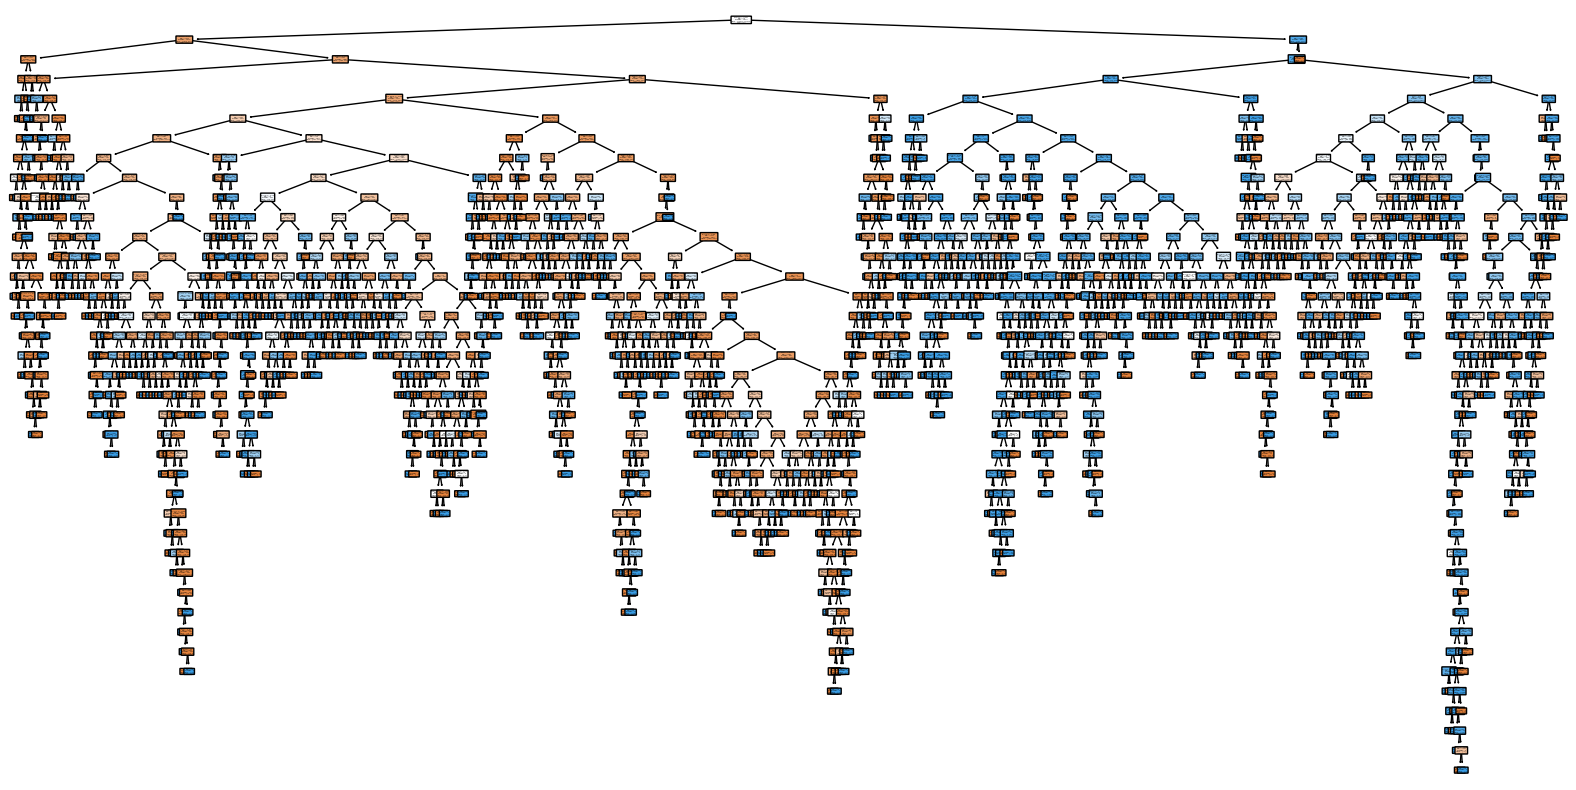

In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select one tree from the forest
estimator = loaded_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          filled=True,
          rounded=True,
          class_names=['NLOS', 'LOS'],
          feature_names=data.columns)
plt.show()

# Support Vector Machine (SVM)

In [9]:
import os
from sklearn.svm import SVC
import pickle

svm = SVC(kernel='linear', random_state=42)
loaded_model = train_and_save_model(svm, X_train, y_train, 'svm_classifier.pkl')

# Predict the labels for the test set with each model
y_pred_svm = loaded_model.predict(X_test)

# Calculate the accuracy of each model
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Print the accuracy of each model
print(f"Accuracy of SVM: {accuracy_svm}")

Accuracy of SVM: 1.0


# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Use the train_and_save_model function to train and save the model
loaded_model = train_and_save_model(log_reg, X_train, y_train, 'logistic_regression_model.pkl')

In [11]:
y_pred_log_reg = loaded_model.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy of Logistic Regression: {accuracy_log_reg}")

Accuracy of Logistic Regression: 1.0


# Gradient Boosting Classifier

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)

# Use the train_and_save_model function to train and save the model
loaded_model = train_and_save_model(gbc, X_train, y_train, 'gradient_boosting_classifier.pkl')


In [13]:
y_pred_gbc = loaded_model.predict(X_test)
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
print(f"Accuracy of Gradient Boosting Classifier: {accuracy_gbc}")


Accuracy of Gradient Boosting Classifier: 1.0


# K-Nearest Neighbors (KNN, K=3)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)
loaded_model = train_and_save_model(knn, X_train, y_train, 'knn_classifier.pkl')


In [15]:
y_pred_knn = loaded_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy of K-Nearest Neighbors: {accuracy_knn}")

Accuracy of K-Nearest Neighbors: 0.5292857142857142


# Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes
nb = GaussianNB()
loaded_model = train_and_save_model(nb, X_train, y_train, 'naive_bayes_classifier.pkl')

Training the model and saving it to ./models/naive_bayes_classifier.pkl


In [17]:
y_pred_nb = loaded_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy of Naive Bayes: {accuracy_nb}")

Accuracy of Naive Bayes: 1.0


# Neural Network

In [18]:
# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

2024-02-28 21:09:48.297789: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 21:09:48.300559: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 21:09:48.339610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 21:09:48.339651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 21:09:48.340854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/100
919/919 [==============================] - 3s 2ms/step - loss: 0.2585 - accuracy: 0.8881 - val_loss: 0.0760 - val_accuracy: 0.9749
Epoch 2/100
919/919 [==============================] - 2s 2ms/step - loss: 0.0224 - accuracy: 0.9935 - val_loss: 0.0367 - val_accuracy: 0.9879
Epoch 3/100
919/919 [==============================] - 2s 2ms/step - loss: 0.0103 - accuracy: 0.9974 - val_loss: 0.0474 - val_accuracy: 0.9863
Epoch 4/100
919/919 [==============================] - 2s 2ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.0212 - val_accuracy: 0.9930
Epoch 5/100
919/919 [==============================] - 2s 2ms/step - loss: 7.9153e-04 - accuracy: 0.9998 - val_loss: 0.0157 - val_accuracy: 0.9948
Epoch 6/100
919/919 [==============================] - 2s 2ms/step - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.0412 - val_accuracy: 0.9879
Epoch 7/100
919/919 [==============================] - 2s 2ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 0.0106 - val_accuracy: 0.